# Problem Definition

Use historical boxscores to predict an NBA player's Steals Per Second (SPS) in a single game. In conjunction with the predicted NBA player's Seconds Played (SP) will be used to predict the total steals of a player in a single game.

### Usage

- The final steals projection will be used along other stat projections to predict a player's Daily Fantasy Sports (DFS) Fantasy Score. 
- The projection will also be used to bet on vegas lines.

# Setup

Import the necessary libraries

In [1]:
# for data
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pyNBA.Data.data import QueryData
from pyNBA.Models.helpers import CleanData
import math

# for features
from pyNBA.Models.features import FeatureCreation
from pyNBA.Models.cluster import Cluster, Evaluate
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from research import Helpers
from statsmodels.graphics.api import abline_plot

# for statistical tests
from scipy.stats import shapiro
import pingouin as pg

# for machine learning
from sklearn import model_selection, preprocessing, ensemble, neighbors, linear_model, svm, neural_network, metrics
import xgboost as xgb
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# for explainer
from lime import lime_tabular

# misc
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

/Users/brandonshimiaie/.virtualenvs/nbavenv/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.3, the latest is 0.3.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


# Factor Determination
Determine the factors that influence a player's Steals Per Second (SPS).

- Historical SPS
    - Season averages
    - Recent performances
    - Home vs. Away
    - Start vs. Bench
    - Rest


- Defense
    - Opponent SPS Allowed
        - Starters vs. Bench Players
        - By position
    - Vegas implied total points

# Data Analysis
Summarize the characteristics of the dataset.

First, I will pull the boxscore data and drop the unessesary rows.

In [2]:
query_data = QueryData()
clean_data = CleanData()

# pull boxscore data
boxscores = query_data.query_boxscore_data()

# we are only interested in the boxscores of healthy and non-resting players
boxscores = clean_data.drop_rows_player_injured(boxscores)
boxscores = clean_data.drop_rows_player_rest(boxscores)

pd.set_option('display.max_columns', None)
display(boxscores.head())

/Users/brandonshimiaie/Projects/sqlite/db/nba.db
2.6.0


,PLAYERID,TEAM,GAMEID,OPP_TEAM,COMMENT,START,SECONDSPLAYED,PTS,FGM,FGA,FG3M,FG3A,FTM,FTA,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,PCT_AST_2PM,PCT_AST_3PM,OREB,OREB_PCT,DREB,DREB_PCT,AST,AST_PCT,AST_RATIO,STL,BLK,TOV,PF,PLUSMINUS,USG_PCT,PACE,ID_x,SEASON,DATE,HTM,VTM,W,ID_y,NAME,POSITION,SCHOOL,COUNTRY,HEIGHT,WEIGHT,DRAFTYEAR,DRAFTROUND,DRAFTNUMBER,BIRTHDATE
0,203906,ORL,0021400001,NOP,,0,179,4,2,2,0,0,0,2,0,0,2,4,0.500,0.0,0,0.000,1.0,0.333,0,0.000,0.0,0,0,0,1,4,0.300,112.63,0021400001,2014-15,2014-10-28,NOP,ORL,ORL,203906,Devyn Marble,Forward,Iowa,USA,78,200,2014,2,56,1992-09-21
1,2584,ORL,0021400001,NOP,,0,247,0,0,1,0,0,0,0,0,0,0,0,0.000,0.0,1,0.250,1.0,0.100,0,0.000,0.0,0,0,0,0,-3,0.100,93.28,0021400001,2014-15,2014-10-28,NOP,ORL,ORL,2584,Willie Green,Guard,Detroit Mercy,USA,75,205,2003,2,41,1981-07-28
2,202690,NOP,0021400001,ORL,,0,1068,2,0,6,0,3,2,2,0,0,0,0,0.000,0.0,0,0.000,0.0,0.000,2,0.133,22.2,1,0,0,3,3,0.146,98.43,0021400001,2014-15,2014-10-28,NOP,ORL,ORL,202690,Jimmer Fredette,Guard,Brigham Young,USA,74,195,2011,1,10,1989-02-25
3,202699,ORL,0021400001,NOP,,1,2192,25,9,18,1,2,6,6,6,5,8,16,0.625,1.0,2,0.048,6.0,0.111,0,0.000,0.0,1,0,4,2,-4,0.289,93.28,0021400001,2014-15,2014-10-28,NOP,ORL,ORL,202699,Tobias Harris,Forward,Tennessee,USA,80,226,2011,1,19,1992-07-15
4,201950,NOP,0021400001,ORL,,1,1622,8,4,11,0,3,0,0,2,2,2,6,0.250,0.0,0,0.000,2.0,0.067,4,0.190,23.5,3,1,2,2,9,0.188,94.99,0021400001,2014-15,2014-10-28,NOP,ORL,ORL,201950,Jrue Holiday,Guard,UCLA,USA,75,205,2009,1,17,1990-06-12


I need to determine the type of each column, as well as the proportion of missing data.

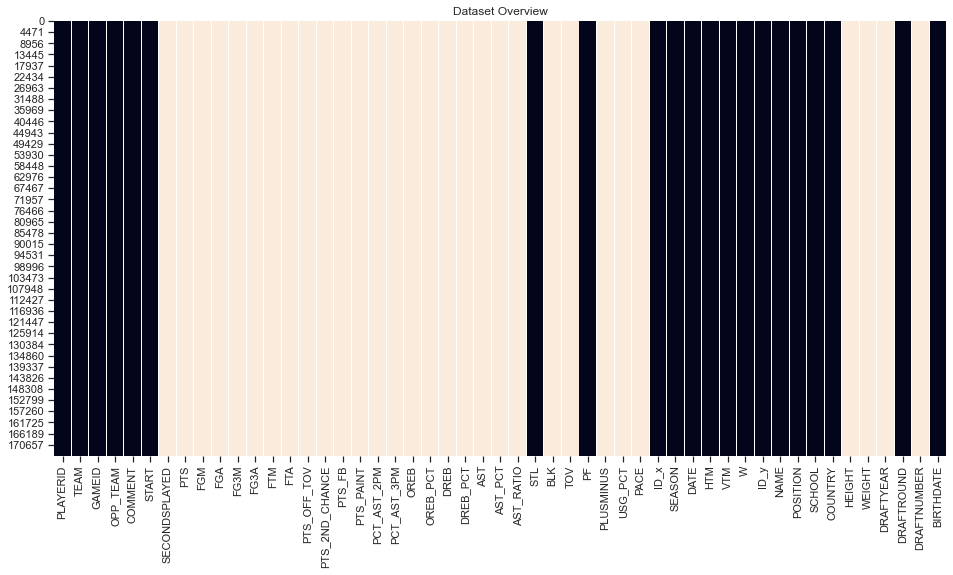

 Categerocial   Numeric   NaN 

Percentage of rows containing at least one missing value: 0.0


In [3]:
helpers = Helpers()

plt.rcParams["figure.figsize"] = (16, 8)
helpers.visualize_dataframe(boxscores)

Great, there is no missing data.

Next I will create the column of our dependant variable, $SPS$.

In [4]:
y = 'Y'
boxscores[y] = boxscores['STL']/boxscores['SECONDSPLAYED']

Let's take a look at the distribution of values of our dependant variable. I will use a histogram to to visualize the probability density distribution of the outcomes of $Y$, and a box plot to graph data groups and outliers.

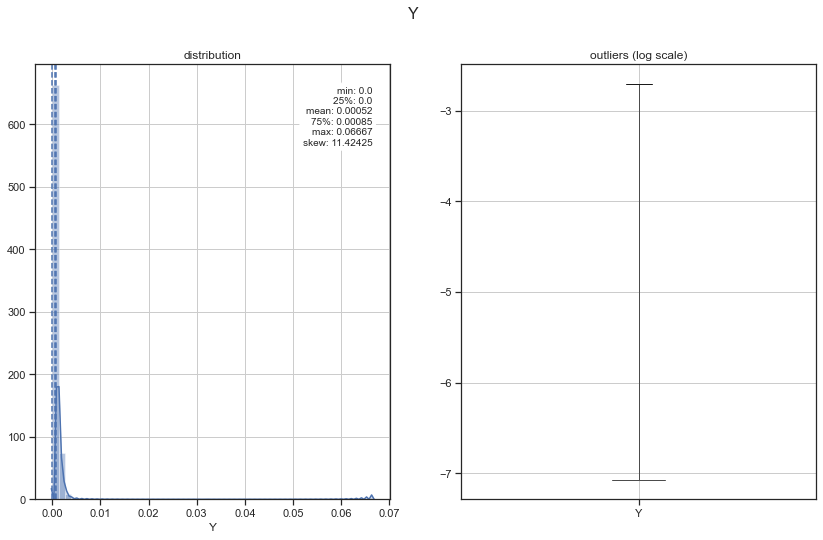

In [5]:
helpers.visualize_variable_distribution(boxscores, y, figsize=(14, 8))

Yikes.

There is clearly an abundance of outliers on the right side of the distribution.

My first guess of the cause of the plethora of outliers is that those outliers come from boxscores in which the player played very few seconds. For example, if a player played for 6 seconds, and made 1 steal, his $SPS$ would be 0.167. That would be an outlier in our distribtion.

Below shows the $SPS$ distribution across different playing times.

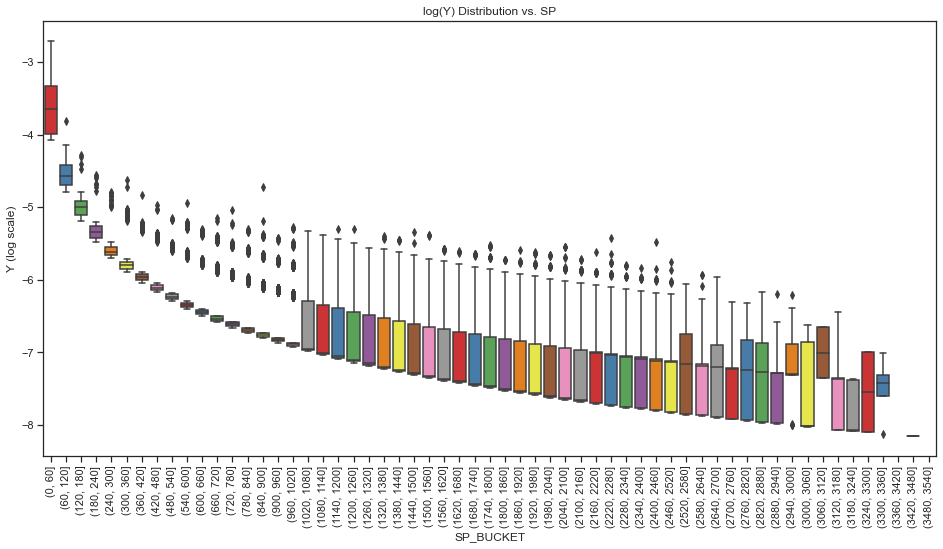

In [6]:
sp_max = boxscores['SECONDSPLAYED'].max()
max_bucket = int(60 * round(float(sp_max)/60))
buckets = [i for i in range(0, max_bucket, 60)]

temp = boxscores[[y, 'SECONDSPLAYED']]
temp['Y (log scale)'] = temp[y].apply(lambda x: np.log(x) if x > 0 else np.nan)
temp['SP_BUCKET'] = pd.cut(temp['SECONDSPLAYED'], buckets)

ax = sns.boxplot(x="SP_BUCKET", y="Y (log scale)", data=temp, palette="Set1")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.title.set_text('log(Y) Distribution vs. SP')
plt.show()
plt.close()

It seems as though the outliers are coming from the (0, 60] seconds played bucket. Let's remove those values from our set of outcomes, and replot the distributions.

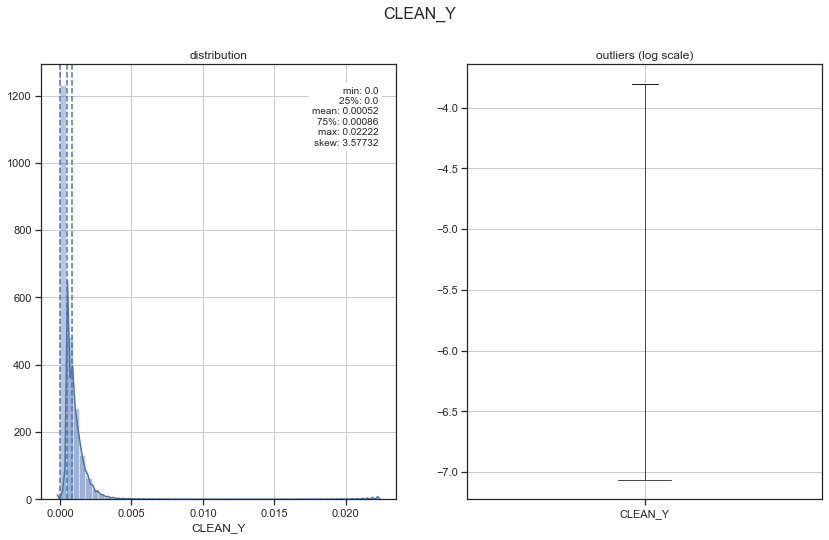

In [7]:
sp_threshold = 60

clean_y = 'CLEAN_Y'
boxscores[clean_y] = boxscores[y]
boxscores.loc[boxscores['SECONDSPLAYED'] <= sp_threshold, clean_y] = np.nan
helpers.visualize_variable_distribution(boxscores, clean_y, figsize=(14, 8))

This distribution looks better. We have far less positive outliers.

However, the distribution is still very skewed right and contains many outliers much higher than our mean.

Let's try looking at the distribtion of log outcomes.

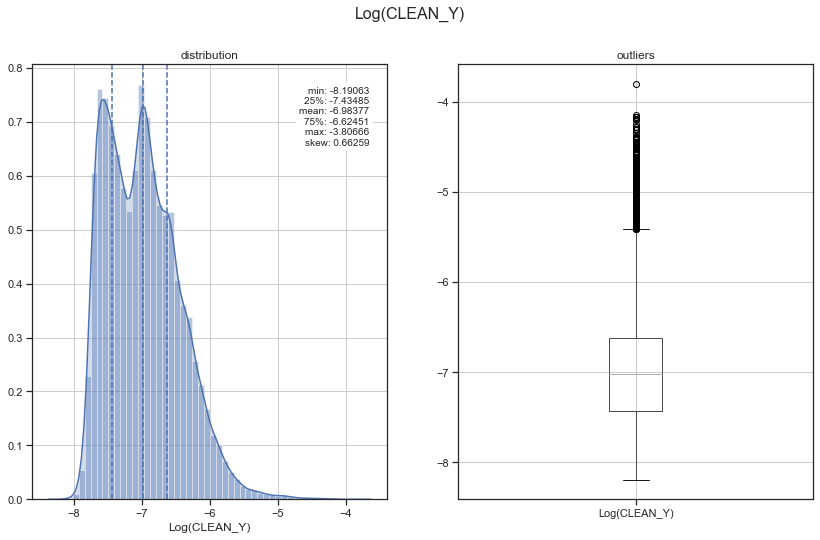

In [8]:
boxscores['Log(CLEAN_Y)'] = np.log(boxscores[clean_y])
boxscores['Log(CLEAN_Y)'] = boxscores['Log(CLEAN_Y)'].replace(-np.inf, np.nan)

helpers.visualize_variable_distribution(boxscores, 'Log(CLEAN_Y)', log_boxplot=False, figsize=(14, 8))

In [9]:
stat, p = shapiro(boxscores['Log(CLEAN_Y)'].dropna())
print(stat, p)

0.9628064632415771 0.0


Much better.

The distribution now contains a roughly equal amount of outliers on the left and right side, is less skewed, and is statistically normal

# Feature Engineering
Create new features from raw data using domain knowlege.

In [10]:
regressors = []
categorical_regressors = []

### Historical SPS
First, I will create features that represent a player's historical $SPS$.

I will start by calculating the running $SPS$ of a player in a season.

In [11]:
feature_creation = FeatureCreation()

boxscores = feature_creation.expanding_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name=y, weight_col_name='SECONDSPLAYED',
    new_col_name='AVG_Y'
)

regressors.append('AVG_Y')

Next, I will calculate the average $SPS$ of a player in the previous games against the same opposing team in the same season.

In [12]:
boxscores = feature_creation.expanding_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'OPP_TEAM', 'PLAYERID'], col_name=y, weight_col_name='SECONDSPLAYED',
    new_col_name='AVG_Y_OPP_TEAM'
)

regressors.append('AVG_Y_OPP_TEAM')

Do more recent steal performances within a season matter more than previous ones?

To answer this, first I will calculate the Autocorrelation between a player's $SPS$ and his previous $SPS$ values:

$$ ACF(X_{0}, X_{i}) $$ <br>

Then, I will calculate the Partial Autocorrelation between between a player's $SPS$ and his previous $SPS$ values, using the lags in between as covariates:

$$ PACF(X_{0}, X_{i}  |  \{X_{j}\}_{0<j<i}) $$ <br>

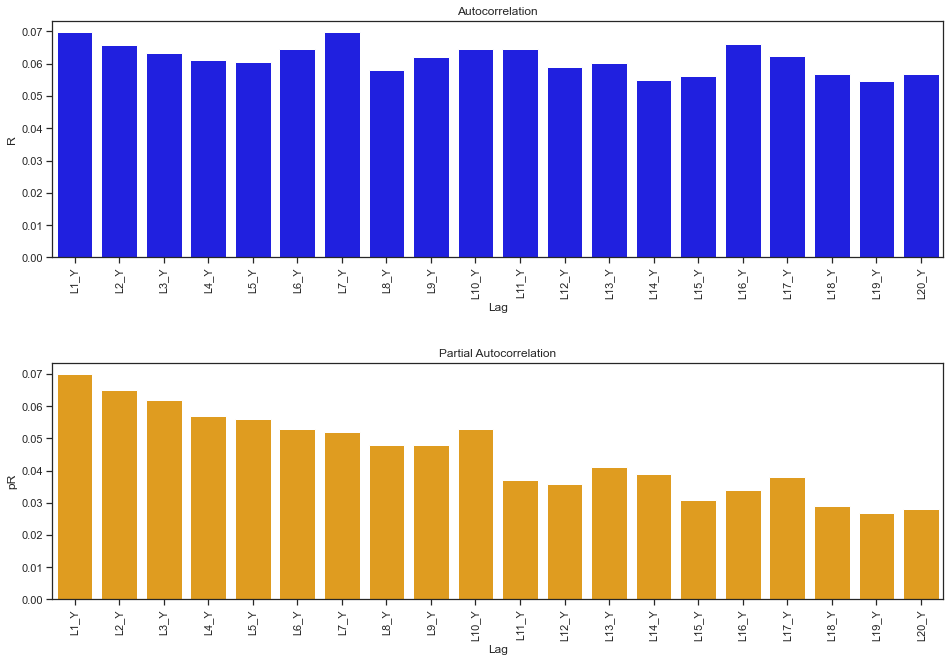

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(14, 10))

x_ticks = []
corrs = []
p_corrs = []
for i in range(1, 21):
    x = 'L{}_{}'.format(str(i), y)

    boxscores = feature_creation.lag(
        df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name=clean_y, new_col_name=x, n_shift=i
    )
    
    corr = boxscores[clean_y].corr(boxscores[x])
    p_corr = pg.partial_corr(data=boxscores, x=x, y=clean_y, covar=x_ticks)
    
    corrs.append(corr)
    p_corrs.append(p_corr['r'][0])
    x_ticks.append(x)
    
corr_df = pd.DataFrame({'R': corrs, 'pR': p_corrs, 'Lag': x_ticks})

sns.barplot(x='Lag', y='R', data=corr_df, color='blue', ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=90)
ax[0].title.set_text('Autocorrelation')

sns.barplot(x='Lag', y='pR', data=corr_df, color='orange', ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=90)
ax[1].title.set_text('Partial Autocorrelation')

fig.tight_layout(pad=3.0)
plt.show()
plt.close()

While the Autocorrelaton of each between $SPS$ and each $SPS_{i}$ is similar, the Partial Autocorrelations exponentially decrease. This tells us that each $X_{i}$ tells us less new information than the preceding lag does. This is a reason for us to add the first lags to our list of regressors. It also makes the case that an exponentially weighted mean of previous lags may be more predictive than a normal mean.

In [14]:
regressors.append('L1_Y')

boxscores = feature_creation.expanding_ewm(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name=y, new_col_name='EWM_Y', alpha=0.90
)

regressors.append('EWM_Y')

Next, I will calculate the partial correlation between $SPS$ and previous moveing averages of $SPS$, using a covariate of the AVG_$SPS$. The peak of this graph will tell us which MA provides the most new information on top of the average.

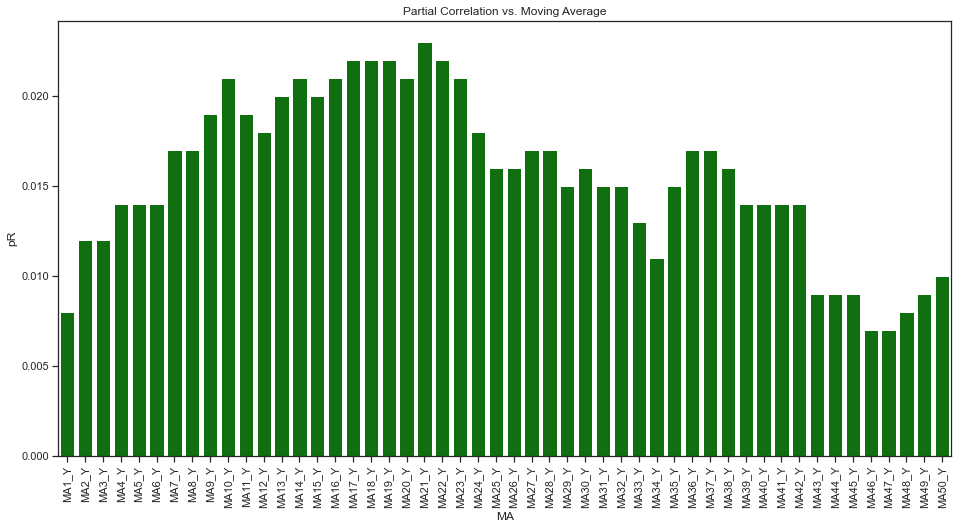

In [15]:
x_ticks = []
p_corrs = []
for i in range(1, 51):
    x = 'MA{}_{}'.format(str(i), y)

    boxscores = feature_creation.rolling_weighted_mean(
        df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name=y, new_col_name=x,
        weight_col_name='SECONDSPLAYED', n_rolling=i, min_periods=math.ceil(i/2)
    )
    
    p_corr = pg.partial_corr(data=boxscores, x=x, y=clean_y, covar=['AVG_Y'])
    
    x_ticks.append(x)
    p_corrs.append(p_corr['r'][0])
    
corr_df = pd.DataFrame({'pR': p_corrs, 'MA': x_ticks})
ax = sns.barplot(x='MA', y='pR', data=corr_df, color='green')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.title.set_text('Partial Correlation vs. Moving Average')
plt.show()
plt.close()

I will use MA2_$SPS$, MA4_$SPS$, and MA10_$SPS$.

In [16]:
regressors.append('MA2_Y')
regressors.append('MA4_Y')
regressors.append('MA10_Y')

Now I will determine if the dependant variable, $Y$, depends on various categorical variables in our data set.

First I will visualize the difference of the distributions and means of $Y$ when a player is playing at Home or Away.

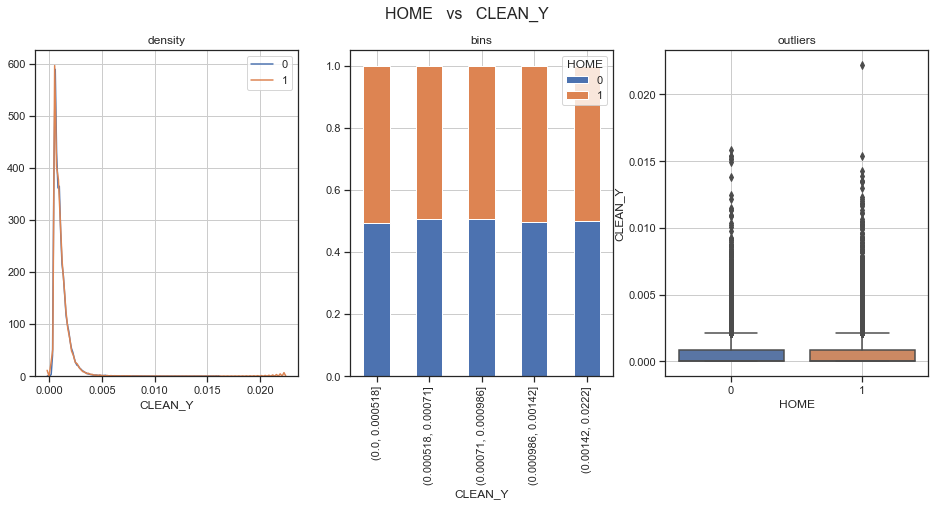

In [17]:
boxscores['HOME'] = 0
boxscores.loc[boxscores['TEAM'] == boxscores['HTM'], 'HOME'] = 1
helpers.visualize_categorical_x_vs_y(boxscores, 'HOME', clean_y)

There does not seem to be a relationship between the location a player plays at and his $SPS$.

Next I will determine if a player's $SPS$ depends on his status as a Starter.

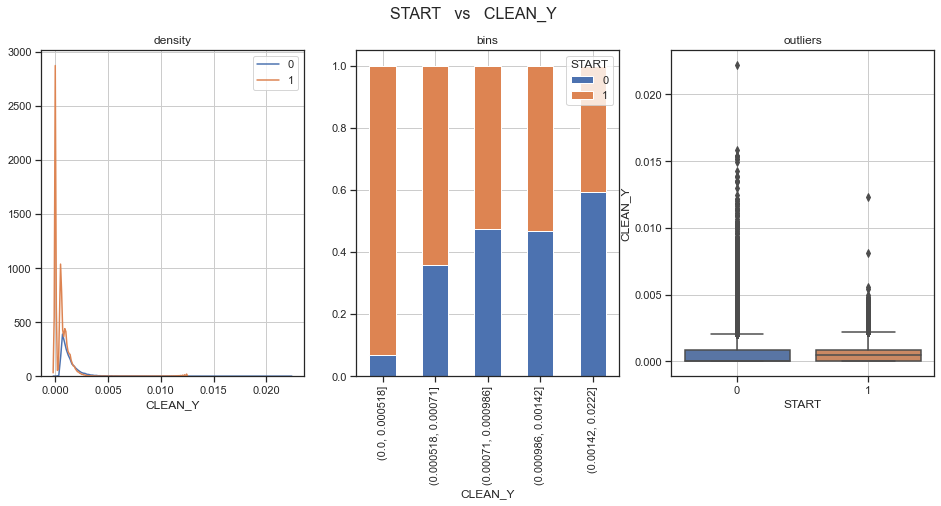

In [18]:
helpers.visualize_categorical_x_vs_y(boxscores, 'START', clean_y)

At a glance, it seems like there may be a slight relationship between starting status and $SPS$.

To confirm this hypothesis, I will investigate the percentage of (season, player) groups in the dataset exhibit a statistically significant difference between their mean $SPS$ when they start and are benched. To test significance, I will use a one-way ANOVA test.

In [19]:
num_valid_player_seasons = 0
significant_player_seasons = []
a = 0.01
for player_season, temp in boxscores.groupby(['SEASON', 'PLAYERID']):
    anova = pg.anova(dv=y, between='START', data=temp, detailed=False)
    p = anova['p-unc'].iloc[0]
    if p != '-':
        num_valid_player_seasons += 1
        if float(p) < a:
            significant_player_seasons.append(player_season)

print('Number of significant (season, player) combinations:', len(significant_player_seasons))
print('Percentage of significant (season, player) combinations:', len(significant_player_seasons)/num_valid_player_seasons)

Number of significant (season, player) combinations: 27
Percentage of significant (season, player) combinations: 0.015237020316027089


The percentage of (season, player) combinations that exibit a significant difference is 2.07%, almost twice our alpha of 1%. This is enough to add a categorical variable that identifies if a player is starting, 'START', to the list of regressors. I will also add the season average $SPS$ of a player in the role he is playing to our list of regressors. I will call this variable: $AVG\_Y\_R$.

In [20]:
regressors.append('START')
categorical_regressors.append('START')

boxscores = feature_creation.expanding_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID', 'START'], col_name=y, weight_col_name='SECONDSPLAYED',
    new_col_name='AVG_Y_R'
)
regressors.append('AVG_Y_R')

Next, I will determine if the number of days a player rests is indicative of his $SPS$.

In [21]:
boxscores = feature_creation.lag(
    df=boxscores, group_col_names=['SEASON', 'PLAYERID'], col_name='DATE', new_col_name='LAST_DATE'
)
boxscores['LAST_DATE'] = boxscores['LAST_DATE'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d') if isinstance(x, str) else ''
)
boxscores['DATE'] = boxscores['DATE'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d') if isinstance(x, str) else ''
)

boxscores['REST'] = boxscores[['DATE', 'LAST_DATE']].apply(
    lambda x: max(min((x[0] - x[1]).days, 5), 1) if not (isinstance(x[0], str) or isinstance(x[1], str)) else np.nan,
    axis=1
)

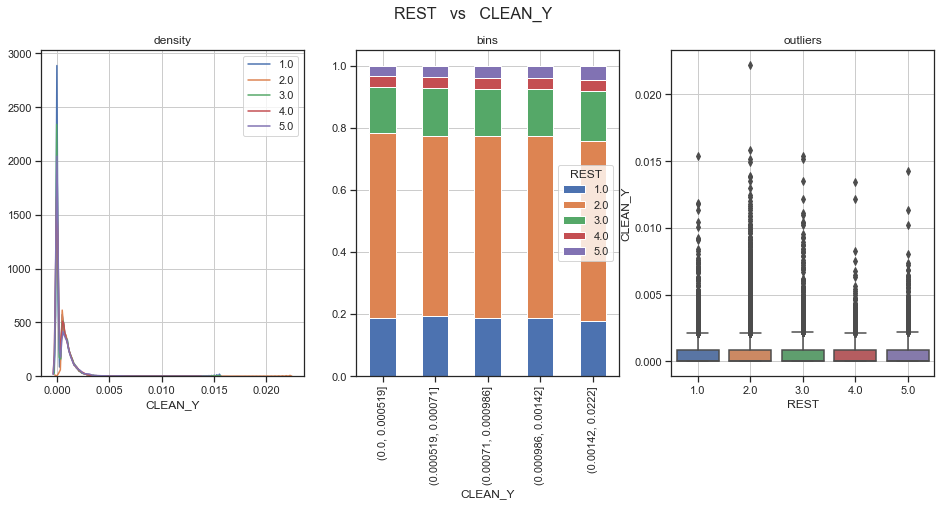

In [22]:
helpers.visualize_categorical_x_vs_y(boxscores, 'REST', clean_y)

No significant relationship.

### Defense
Next, I will create features based on the defense of the opposing team.

First, I will calculate the steal defense of each team on a game-to-game basis. I will define three metrics to measure steal defense:

$$TEAM\_Y\_DIFF\_ALLOWED =  TEAM\_Y\_ALLOWED - TEAM\_Y\_AVG$$

where $TEAM\_Y\_ALLOWED$ is the $SPS$ allowed to the opposing team and $TEAM\_Y\_AVG$ is the $SPS$ of that team throughout the season coming into the game.

In [23]:
boxscores = feature_creation.expanding_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='STL', new_col_name='AVG_STL'
)
boxscores = feature_creation.expanding_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='SECONDSPLAYED', new_col_name='AVG_SP'
)

temp = boxscores.dropna(subset=['STL', 'SECONDSPLAYED', 'AVG_STL', 'AVG_SP'])
grouped_defensive_boxscores = temp.groupby(['SEASON', 'DATE', 'OPP_TEAM']).apply(
    lambda x: pd.Series({
        'TEAM_Y_ALLOWED': x['STL'].sum()/x['SECONDSPLAYED'].sum(),
        'TEAM_Y_AVG': x['AVG_STL'].sum()/x['AVG_SP'].sum()
    })
).reset_index()

grouped_defensive_boxscores['TEAM_Y_DIFF_ALLOWED'] = grouped_defensive_boxscores['TEAM_Y_ALLOWED'] - grouped_defensive_boxscores['TEAM_Y_AVG']

Next, I will visualize the defense of each team for each season in the dataset. I will also run a one-way ANOVA test to determine if the mean $TEAM\_Y\_DIFF\_ALLOWED$ differs among the teams in each season.

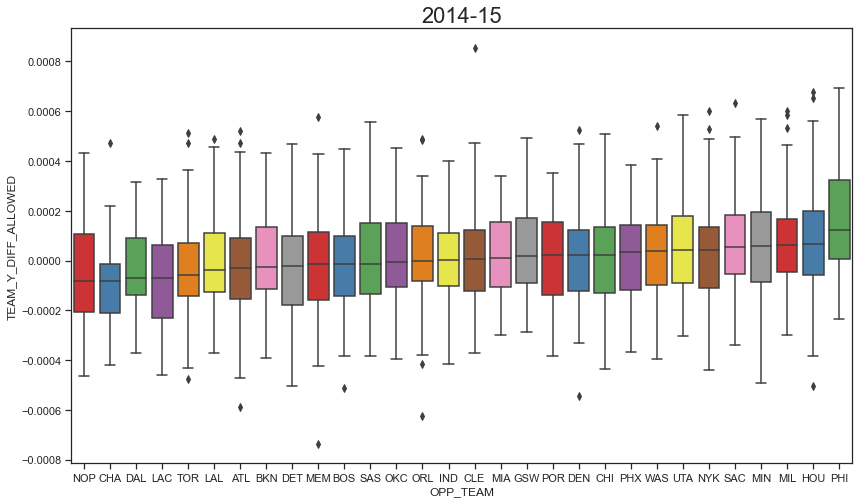

Team defenses are statistically siginficantly different


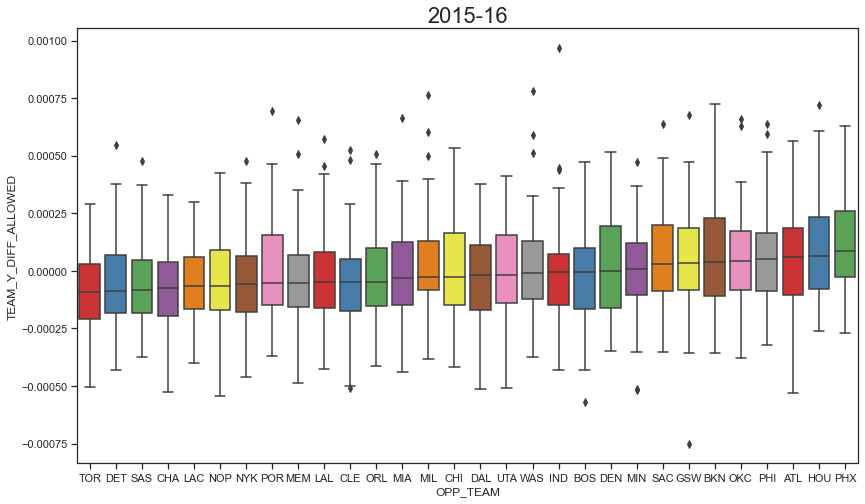

Team defenses are statistically siginficantly different


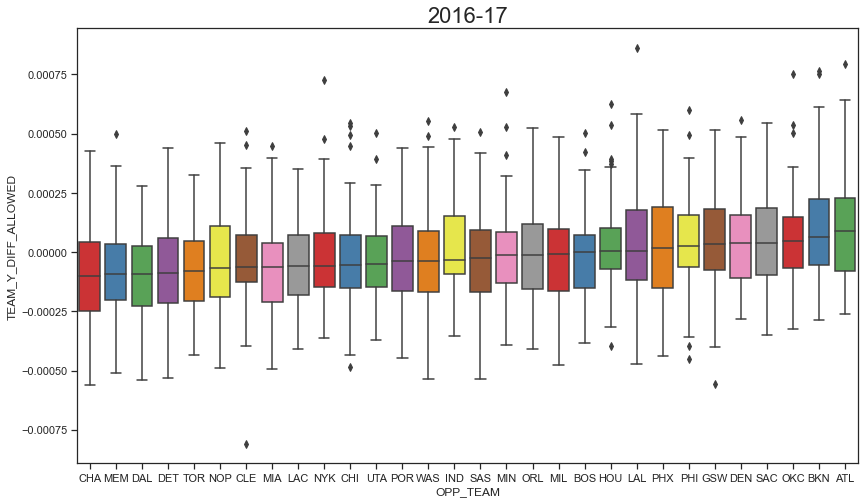

Team defenses are statistically siginficantly different


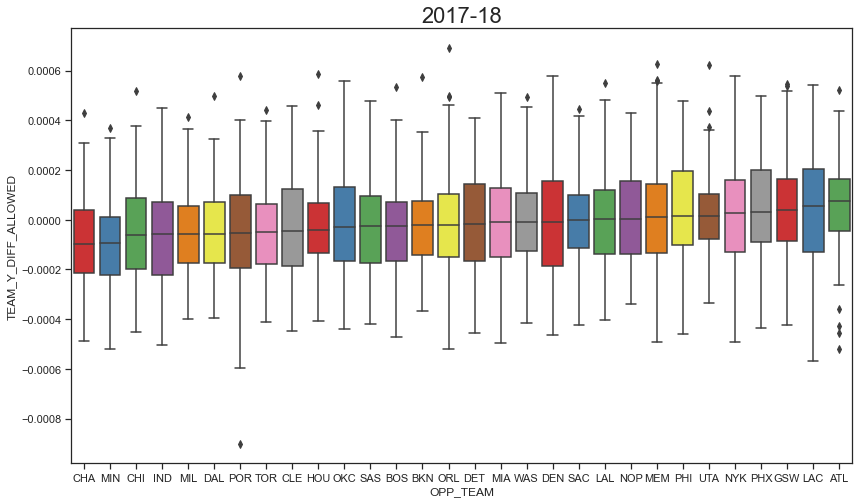

Team defenses are statistically siginficantly different


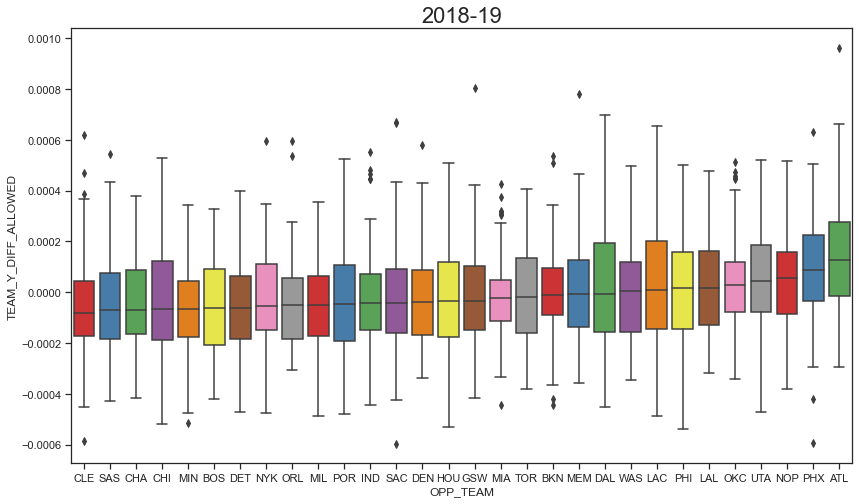

Team defenses are statistically siginficantly different


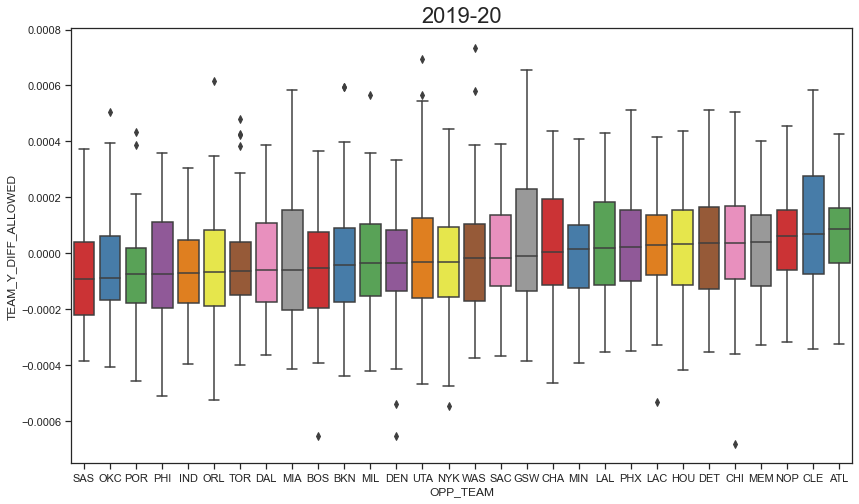

Team defenses are statistically siginficantly different


In [24]:
a = 0.01
for season, temp in grouped_defensive_boxscores.groupby(['SEASON']):
    plt.figure(figsize=(14, 8))
    plt.title(season,fontsize=22)
    opp_team_def = [
        (opp_team, temp2['TEAM_Y_DIFF_ALLOWED'].median()) for opp_team, temp2 in temp.groupby('OPP_TEAM')
    ]
    opp_team_def.sort(key = lambda x: x[1])
    opp_teams = [i[0] for i in opp_team_def]
    sns.boxplot(x="OPP_TEAM", y="TEAM_Y_DIFF_ALLOWED", data=temp, palette="Set1", order=opp_teams)
    
    plt.show()
    plt.close()
    
    anova = pg.anova(dv='TEAM_Y_DIFF_ALLOWED', between='OPP_TEAM', data=temp, detailed=True)
    p = anova['p-unc'].iloc[0]
    if p < a:
        print('Team defenses are statistically siginficantly different')
    else:
        print('Team defenses are not statistically siginficantly different')

Now, I will calculate the average steal defense of the opposing team across all previous games in a season, $AVG\_TEAM\_Y\_DIFF\_ALLOWED$.

In [25]:
grouped_defensive_boxscores = feature_creation.expanding_mean(
    df=grouped_defensive_boxscores, group_col_names=['SEASON', 'OPP_TEAM'], col_name='TEAM_Y_DIFF_ALLOWED', new_col_name='AVG_TEAM_Y_DIFF_ALLOWED',
    order_idx_name='DATE', min_periods=5
)

boxscores = boxscores.merge(grouped_defensive_boxscores, on=['SEASON', 'DATE', 'OPP_TEAM'], how='left')

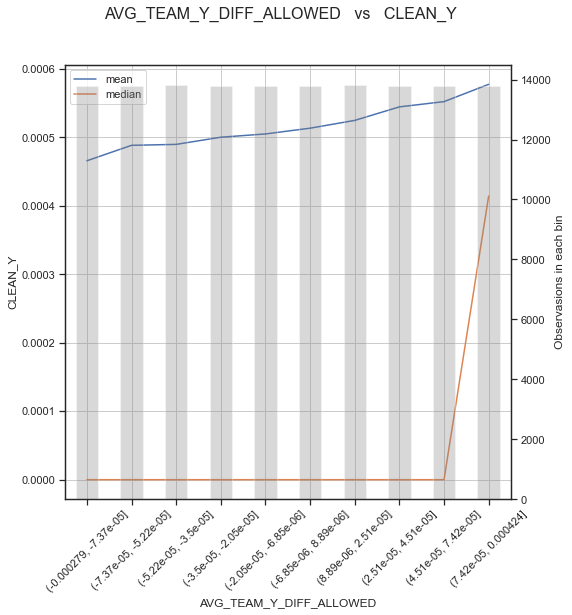

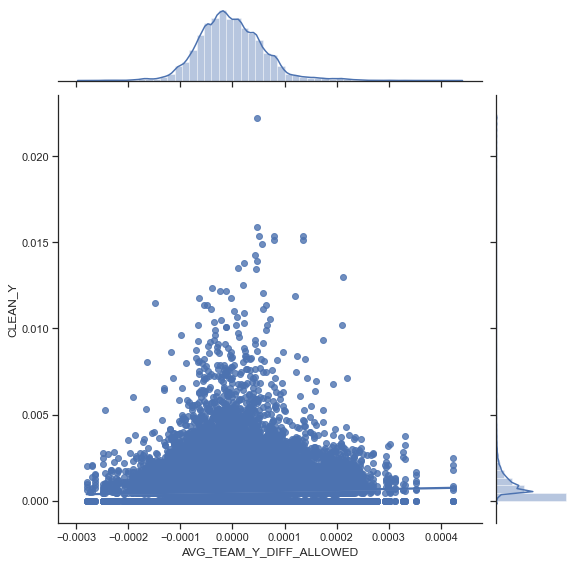

In [26]:
helpers.visualize_numeric_x_vs_y(boxscores, 'AVG_TEAM_Y_DIFF_ALLOWED', clean_y, figsize=(8, 8))

In [27]:
regressors.append('AVG_TEAM_Y_DIFF_ALLOWED')

The metrics above track the opposing team's steal defense on all players. However, an opposing team's steal defense may differ among starts and bench players, as each set will have a mostly different group of opposing players.

I will use the variable $TEAM\_Y\_DIFF\_ALLOWED\_P$ to quantify a team's steal defense on opposing players by role (guard/forward/center).

In [28]:
boxscores['NORM_POS'] = boxscores['POSITION'].apply(lambda x: x if '-' not in x else x.split('-')[0])

temp = boxscores.dropna(subset=['STL', 'SECONDSPLAYED', 'AVG_STL', 'AVG_SP'])
grouped_defensive_boxscores = temp.groupby(['SEASON', 'DATE', 'NORM_POS', 'OPP_TEAM']).apply(
    lambda x: pd.Series({
        'TEAM_Y_ALLOWED_P': x['STL'].sum()/x['SECONDSPLAYED'].sum(),
        'TEAM_Y_AVG_P': x['AVG_STL'].sum()/x['AVG_SP'].sum()
    })
).reset_index()

grouped_defensive_boxscores['TEAM_Y_DIFF_ALLOWED_P'] = grouped_defensive_boxscores['TEAM_Y_ALLOWED_P'] - grouped_defensive_boxscores['TEAM_Y_AVG_P']

grouped_defensive_boxscores = feature_creation.expanding_mean(
    df=grouped_defensive_boxscores, group_col_names=['SEASON', 'OPP_TEAM', 'NORM_POS'], col_name='TEAM_Y_DIFF_ALLOWED_P',
    new_col_name='AVG_TEAM_Y_DIFF_ALLOWED_P', order_idx_name='DATE', min_periods=5
)

boxscores = boxscores.merge(grouped_defensive_boxscores, on=['SEASON', 'DATE', 'OPP_TEAM', 'NORM_POS'], how='left')

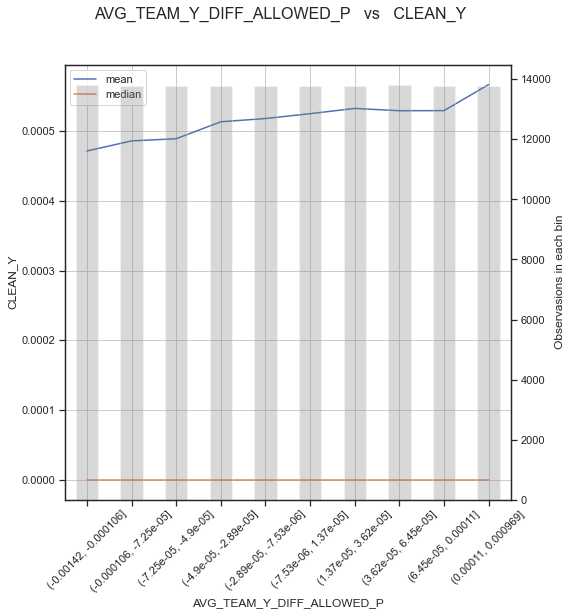

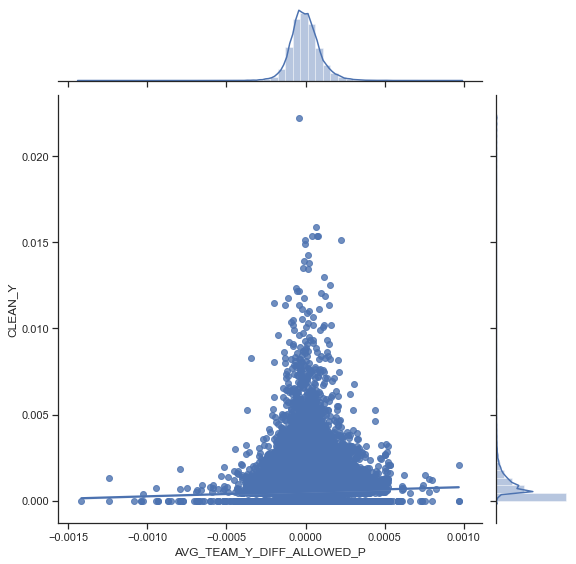

In [29]:
helpers.visualize_numeric_x_vs_y(boxscores, 'AVG_TEAM_Y_DIFF_ALLOWED_P', clean_y, figsize=(8, 8))

In [30]:
regressors.append('AVG_TEAM_Y_DIFF_ALLOWED_P')

I will also include the vegas implied game point total as a feature.

In [31]:
odds = query_data.query_odds_data()
odds['TOTAL'] = odds['TOTAL'].replace(['PK', '-'], np.nan)
full_game_odds = odds.loc[odds['PERIOD'] == 'Full Game']

In [32]:
full_game_odds['DATE'] = full_game_odds['DATE'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d') if isinstance(x, str) else ''
)

boxscores = boxscores.merge(full_game_odds, on=['DATE', 'TEAM'], how='left')

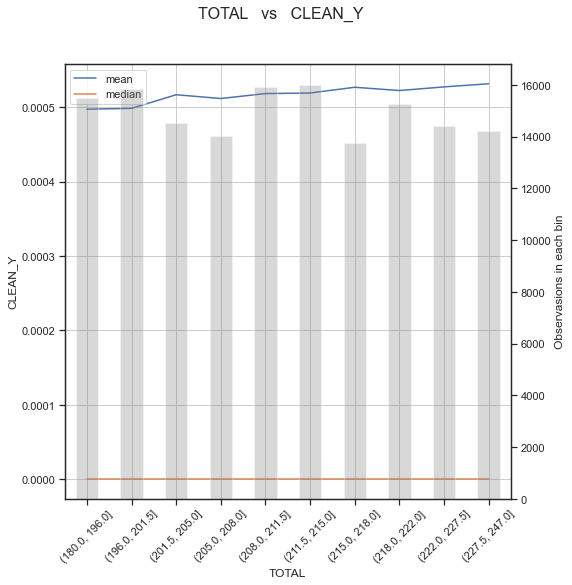

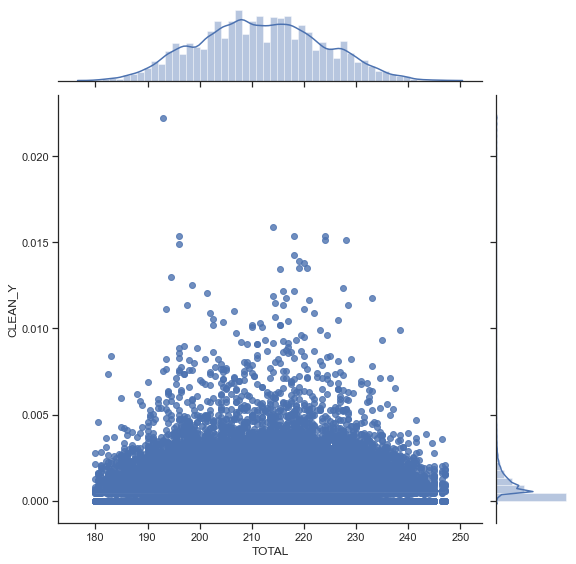

In [33]:
helpers.visualize_numeric_x_vs_y(boxscores, 'TOTAL', clean_y, figsize=(8, 8))

In [34]:
regressors.append('TOTAL')

### Weights
Lastly, I will add a column to weight each $Y$ value. I do not care about each occurance of the dependant variable equally; the $SPS$ of a player who made 1 steal in 180 seconds should not be weighted the same as the $SPS$ of a plyer who made 10 steals in 1800 seconds. 

The weight I will use will be a product of functions of the amount of seconds played in a game and the sum of seconds played by a player throughout that season:

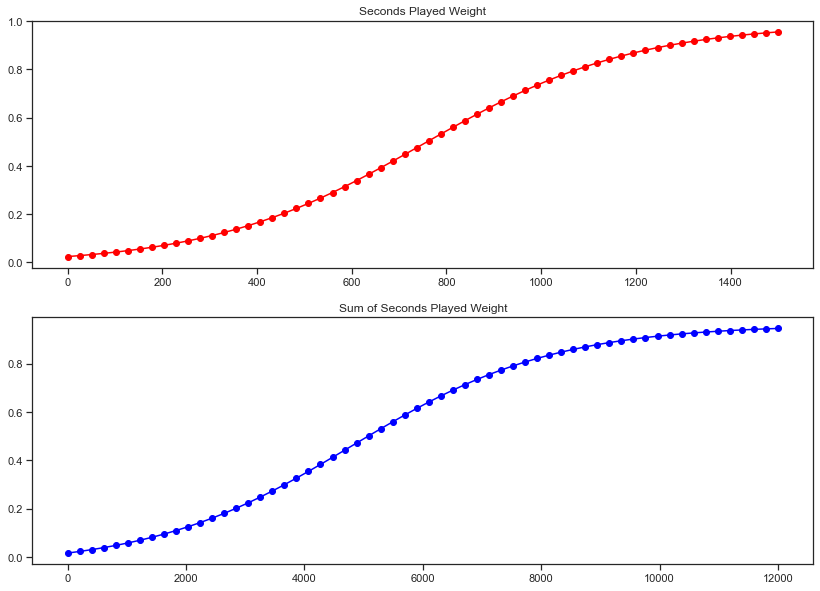

In [35]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(14, 10))

sp_weight_func = lambda x: 1/(1 + np.exp((-0.80*x + 600)/180)) - 0.01
sp_in_array = np.linspace(0, 60*25, 60)
sp_out_array = sp_weight_func(sp_in_array) 

tsp_weight_func = lambda x: 1/(1 + np.exp((-0.175*x + 840)/300)) - 0.04
tsp_in_array = np.linspace(0, 60*20*10, 60)
tsp_out_array = tsp_weight_func(tsp_in_array)

ax[0].title.set_text("Seconds Played Weight") 
ax[0].plot(sp_in_array, sp_out_array, color ='red', marker="o")

ax[1].title.set_text("Sum of Seconds Played Weight") 
ax[1].plot(tsp_in_array, tsp_out_array, color ='blue', marker="o") 
plt.show() 

In [36]:
boxscores = feature_creation.expanding_sum(
    df=boxscores, group_col_names=['SEASON', 'PLAYERID'], col_name='SECONDSPLAYED', new_col_name='SUM_SP'
)

w = 'WEIGHT'
boxscores[w] = boxscores['SECONDSPLAYED'].apply(sp_weight_func) * boxscores['SUM_SP'].apply(tsp_weight_func)

Some features we created to track historical performances mean less if the player has played less games/ minutes. To tell the non-linear models how much the player has played, I will create 2 regressors: number of games played ($COUNT\_GP$) and average seconds played ($AVG\_SP$)

In [37]:
boxscores['GP'] = 1
boxscores = feature_creation.expanding_sum(df=boxscores, group_col_names=['SEASON', 'PLAYERID'], col_name='GP', new_col_name='COUNT_GP')
regressors.append('COUNT_GP')


regressors.append('AVG_SP')

# Preprocessing
Now that I have created all the features I found to be indicative of our dependant variable, I will prepare the data to be suitable for a predictive model.

The first thing I will do is handle missing data.

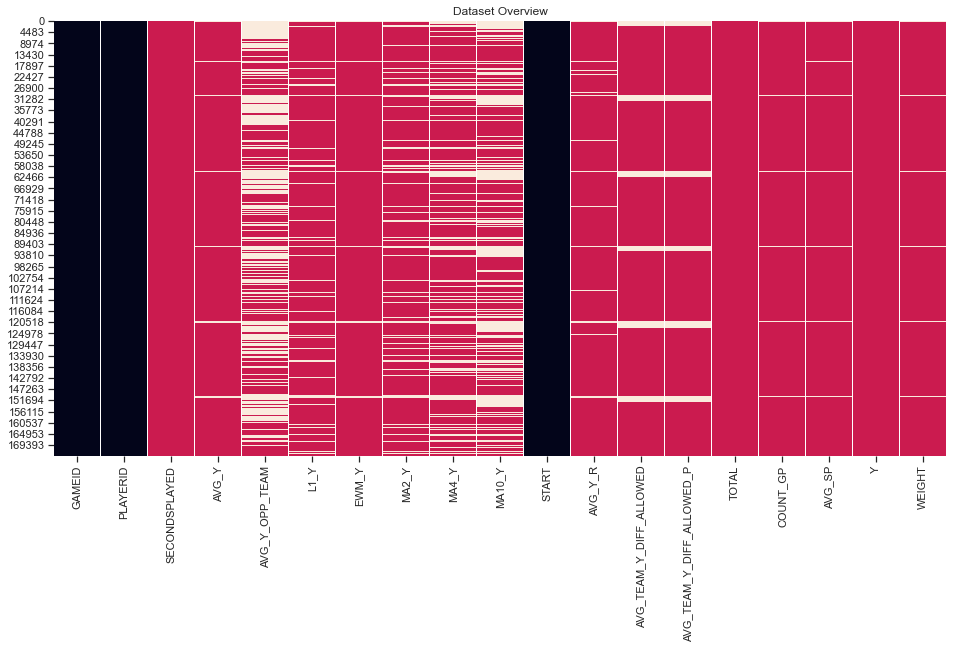

 Categerocial   Numeric   NaN 

Percentage of rows containing at least one missing value: 58.39


In [38]:
feature_matrix = boxscores[['GAMEID', 'PLAYERID', 'SECONDSPLAYED'] + regressors + [y] + [w]]

#drop games in which players played a minute or less
feature_matrix = feature_matrix.loc[feature_matrix['SECONDSPLAYED'] > 60]

helpers.visualize_dataframe(feature_matrix)

In [39]:
feature_matrix['AVG_Y_OPP_TEAM'] = feature_matrix['AVG_Y_OPP_TEAM'].fillna(feature_matrix['AVG_Y'])

feature_matrix['L1_Y'] = feature_matrix['L1_Y'].fillna(feature_matrix['AVG_Y'])
feature_matrix['EWM_Y'] = feature_matrix['EWM_Y'].fillna(feature_matrix['AVG_Y'])

feature_matrix['MA2_Y'] = feature_matrix['MA2_Y'].fillna(feature_matrix['AVG_Y'])
feature_matrix['MA4_Y'] = feature_matrix['MA4_Y'].fillna(feature_matrix['MA2_Y'])
feature_matrix['MA10_Y'] = feature_matrix['MA10_Y'].fillna(feature_matrix['MA4_Y'])

feature_matrix['AVG_Y_R'] = feature_matrix['AVG_Y_R'].fillna(feature_matrix['AVG_Y'])

feature_matrix['AVG_TEAM_Y_DIFF_ALLOWED'] = feature_matrix['AVG_TEAM_Y_DIFF_ALLOWED'].fillna(0)
feature_matrix['AVG_TEAM_Y_DIFF_ALLOWED_P'] = feature_matrix['AVG_TEAM_Y_DIFF_ALLOWED_P'].fillna(0)

feature_matrix['TOTAL'] = feature_matrix['TOTAL'].fillna(200)

feature_matrix['COUNT_GP'] = feature_matrix['COUNT_GP'].fillna(0)

# we can predict Y for a player as long as AVG_Y is not nan
feature_matrix = feature_matrix.dropna(subset=['AVG_Y'])

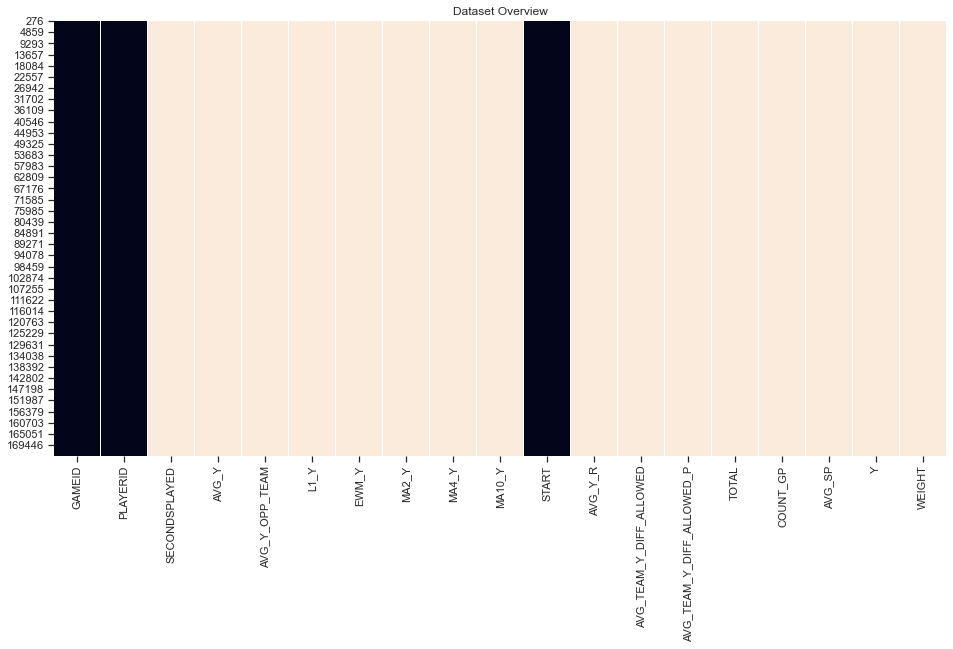

 Categerocial   Numeric   NaN 

Percentage of rows containing at least one missing value: 0.0


In [40]:
helpers.visualize_dataframe(feature_matrix)

# Model/Feature Selection
Finally, it's time to build the model. I will first iterate through various model types. Within each model iteration, I will isolate the important features. I will also try predicting the log transform of the dependant variable, and scaling the numeric columns, and pick whatever (Model, Feature Subset, \[Log Transform, No Transform\], \[Scale, No Scale\]) combination yeilds the lowest average MSE after 5-fold cross validation.

In [43]:
linear_models = [
    linear_model.LinearRegression()
#     linear_model.Ridge(),
#     linear_model.ElasticNet()
]

neighbor_models = [
#     neighbors.KNeighborsRegressor()
]

boosted_models = [
    xgb.XGBRegressor(objective='reg:squarederror', eval_metric='mae', learning_rate=0.1, n_estimators=500, tree_method='hist'),
    CatBoostRegressor(eval_metric='MAE', learning_rate=0.1, n_estimators=500, silent=True)
    
]

neural_networks = [
    neural_network.MLPRegressor(max_iter=10000, early_stopping=True, random_state=42)
]

models = linear_models + neighbor_models + boosted_models + neural_networks

transformers = [
    {
        'Function': lambda x: x,
        'Inverse Function': lambda x: x,
        'Name': 'None'
    },
    {
        'Function': lambda x: np.log(x + 1),
        'Inverse Function': lambda x: np.exp(x) - 1,
        'Name': 'Log'
    }
]

numeric_regressors = list(set(regressors) - set(categorical_regressors))
numeric_columns = numeric_regressors + [y]

min_score = float('inf')
best_model = None
for model in models:
    for transformer in transformers:
        for scale in [False, True]:
            
            # transform numeric columns
            temp_feature_matrix = feature_matrix.copy()
            temp_feature_matrix[numeric_columns] = temp_feature_matrix[numeric_columns].apply(
                transformer['Function'], axis=1
            )
            
            # scale numeric features
            if scale:
                x_scaler = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
                temp_feature_matrix[numeric_regressors] = x_scaler.fit_transform(temp_feature_matrix[numeric_regressors])
                
                y_scaler = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
                temp_feature_matrix[[y]] = y_scaler.fit_transform(temp_feature_matrix[[y]])

            # feature selection
            X = temp_feature_matrix[regressors]
            Y = temp_feature_matrix[y]
            W = temp_feature_matrix[w]

            if model in (neighbor_models + neural_networks):
                selected_features = regressors.copy()
            else:
                model.fit(X, Y, sample_weight=W)
                
                # importance
                importance_selector = SelectFromModel(model, threshold='0.75*median')
                importance_selector = importance_selector.fit(X, Y, sample_weight=W)
                importance_support = importance_selector.get_support()
                
                # rank
                rank_selector = RFE(model)
                rank_selector = rank_selector.fit(X, Y)
                rank_support = rank_selector.ranking_
                median_rank = np.median(rank_support)
                
                selected_features = []
                for feature, importance_flag, rank in zip(list(X.columns), importance_support, rank_support):
                    # select the feature if it's important, or has a low rank
                    if importance_flag or (rank <= median_rank):
                        selected_features.append(feature)

            X = temp_feature_matrix[selected_features].values
            Y = temp_feature_matrix[y].values
            W = temp_feature_matrix[w].values
            
            # cross validation
            scores = []
            cv = model_selection.KFold(n_splits=5, shuffle=True)
            for train, test in cv.split(X, Y, W):
                if model in (neural_networks + neighbor_models):
                    prediction = model.fit(X[train], Y[train]).predict(X[test])
                else:
                    prediction = model.fit(X[train], Y[train], sample_weight=W[train]).predict(X[test])
                true = Y[test]

                if scale:
                    prediction = y_scaler.inverse_transform(prediction.reshape(-1,1)).reshape(-1)
                    true = y_scaler.inverse_transform(true.reshape(-1,1)).reshape(-1)

                prediction = transformer['Inverse Function'](prediction)
                true = transformer['Inverse Function'](true)
                
                scores.append(metrics.mean_absolute_error(prediction, true, sample_weight=W[test]))

            mean_score = np.mean(scores)
            print('\nModel:', model)
            print('Transformer:', transformer['Name'])
            print('Scale:', scale)
            print('Selected Features:', selected_features)
            print('Mean MAE:', mean_score)
            if mean_score < min_score:
                min_score = mean_score
                best_model = (model, transformer['Name'], scale, selected_features)
print()
print(best_model, min_score)


Model: LinearRegression()
Transformer: None
Scale: False
Selected Features: ['AVG_Y', 'L1_Y', 'EWM_Y', 'MA2_Y', 'MA4_Y', 'MA10_Y', 'AVG_Y_R', 'AVG_TEAM_Y_DIFF_ALLOWED', 'AVG_TEAM_Y_DIFF_ALLOWED_P']
Mean MAE: 0.0004870576790371803

Model: LinearRegression()
Transformer: None
Scale: True
Selected Features: ['AVG_Y', 'EWM_Y', 'MA2_Y', 'MA10_Y', 'AVG_Y_R', 'AVG_TEAM_Y_DIFF_ALLOWED', 'AVG_TEAM_Y_DIFF_ALLOWED_P', 'TOTAL', 'COUNT_GP', 'AVG_SP']
Mean MAE: 0.0004866783185113589

Model: LinearRegression()
Transformer: Log
Scale: False
Selected Features: ['AVG_Y', 'L1_Y', 'EWM_Y', 'MA2_Y', 'MA4_Y', 'MA10_Y', 'AVG_Y_R', 'AVG_TEAM_Y_DIFF_ALLOWED', 'AVG_TEAM_Y_DIFF_ALLOWED_P']
Mean MAE: 0.0004870510575977056

Model: LinearRegression()
Transformer: Log
Scale: True
Selected Features: ['AVG_Y', 'EWM_Y', 'MA2_Y', 'MA10_Y', 'START', 'AVG_Y_R', 'AVG_TEAM_Y_DIFF_ALLOWED', 'AVG_TEAM_Y_DIFF_ALLOWED_P', 'TOTAL', 'COUNT_GP', 'AVG_SP']
Mean MAE: 0.0004867367017955987

Model: XGBRegressor(base_score=0.5, booste

The best model is a Catboost model with no log transformations or scaling.

# Parameter Tuning
Now, I will use Grid Search Cross Validation to find the CatBoostRegressor paramters that yeild the lowest average MSE on the test set.

In [44]:
selected_features =  ['AVG_Y', 'AVG_Y_OPP_TEAM', 'L1_Y', 'EWM_Y', 'MA2_Y', 'MA4_Y', 'MA10_Y', 'AVG_Y_R',
                      'AVG_TEAM_Y_DIFF_ALLOWED', 'AVG_TEAM_Y_DIFF_ALLOWED_P', 'TOTAL', 'COUNT_GP', 'AVG_SP']
# selected_features = best_model[3]
X = feature_matrix[selected_features]
Y = feature_matrix[y]
W = feature_matrix[w]
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, Y, W, test_size=0.25, random_state=1)

In [45]:
model = CatBoostRegressor()

model_params = {
    'depth': [4, 6, 8, 10],
    'learning_rate' : [0.01, 0.02, 0.05, 0.1],
    'num_boost_round': [5000],
    'eval_metric': ['MAE']
}

grid = GridSearchCV(estimator=model, param_grid=model_params, scoring='neg_mean_absolute_error', cv=2, n_jobs=-1)

fit_params = {
    "early_stopping_rounds": 25,
    "eval_set": (X_test, y_test),
    'sample_weight': w_train
}

grid.fit(X_train, y_train, **fit_params)    

print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    

print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)

print("\n The best score across ALL searched params:\n", grid.best_score_)

print("\n The best parameters across ALL searched params:\n", grid.best_params_)

print("\n ========================================================")

0:	learn: 0.0004994	test: 0.0005458	best: 0.0005458 (0)	total: 25.9ms	remaining: 2m 9s
1:	learn: 0.0004991	test: 0.0005456	best: 0.0005456 (1)	total: 43.7ms	remaining: 1m 49s
2:	learn: 0.0004989	test: 0.0005454	best: 0.0005454 (2)	total: 56.8ms	remaining: 1m 34s
3:	learn: 0.0004986	test: 0.0005452	best: 0.0005452 (3)	total: 71.4ms	remaining: 1m 29s
4:	learn: 0.0004984	test: 0.0005450	best: 0.0005450 (4)	total: 84.6ms	remaining: 1m 24s
5:	learn: 0.0004982	test: 0.0005448	best: 0.0005448 (5)	total: 99.3ms	remaining: 1m 22s
6:	learn: 0.0004979	test: 0.0005446	best: 0.0005446 (6)	total: 113ms	remaining: 1m 20s
7:	learn: 0.0004977	test: 0.0005444	best: 0.0005444 (7)	total: 127ms	remaining: 1m 19s
8:	learn: 0.0004975	test: 0.0005442	best: 0.0005442 (8)	total: 140ms	remaining: 1m 17s
9:	learn: 0.0004973	test: 0.0005440	best: 0.0005440 (9)	total: 154ms	remaining: 1m 16s
10:	learn: 0.0004971	test: 0.0005438	best: 0.0005438 (10)	total: 167ms	remaining: 1m 15s
11:	learn: 0.0004969	test: 0.0005436

93:	learn: 0.0004889	test: 0.0005364	best: 0.0005364 (93)	total: 1.56s	remaining: 1m 21s
94:	learn: 0.0004889	test: 0.0005364	best: 0.0005364 (94)	total: 1.58s	remaining: 1m 21s
95:	learn: 0.0004888	test: 0.0005363	best: 0.0005363 (95)	total: 1.6s	remaining: 1m 21s
96:	learn: 0.0004888	test: 0.0005363	best: 0.0005363 (96)	total: 1.61s	remaining: 1m 21s
97:	learn: 0.0004887	test: 0.0005362	best: 0.0005362 (97)	total: 1.62s	remaining: 1m 21s
98:	learn: 0.0004887	test: 0.0005362	best: 0.0005362 (98)	total: 1.64s	remaining: 1m 20s
99:	learn: 0.0004887	test: 0.0005362	best: 0.0005362 (99)	total: 1.65s	remaining: 1m 20s
100:	learn: 0.0004886	test: 0.0005362	best: 0.0005362 (100)	total: 1.66s	remaining: 1m 20s
101:	learn: 0.0004886	test: 0.0005361	best: 0.0005361 (101)	total: 1.67s	remaining: 1m 20s
102:	learn: 0.0004885	test: 0.0005361	best: 0.0005361 (102)	total: 1.69s	remaining: 1m 20s
103:	learn: 0.0004885	test: 0.0005360	best: 0.0005360 (103)	total: 1.7s	remaining: 1m 20s
104:	learn: 0.0

190:	learn: 0.0004866	test: 0.0005342	best: 0.0005342 (190)	total: 3.01s	remaining: 1m 15s
191:	learn: 0.0004866	test: 0.0005342	best: 0.0005342 (191)	total: 3.03s	remaining: 1m 15s
192:	learn: 0.0004866	test: 0.0005342	best: 0.0005342 (192)	total: 3.05s	remaining: 1m 15s
193:	learn: 0.0004866	test: 0.0005342	best: 0.0005342 (193)	total: 3.06s	remaining: 1m 15s
194:	learn: 0.0004865	test: 0.0005342	best: 0.0005342 (194)	total: 3.08s	remaining: 1m 15s
195:	learn: 0.0004865	test: 0.0005342	best: 0.0005342 (195)	total: 3.09s	remaining: 1m 15s
196:	learn: 0.0004865	test: 0.0005341	best: 0.0005341 (196)	total: 3.11s	remaining: 1m 15s
197:	learn: 0.0004865	test: 0.0005341	best: 0.0005341 (197)	total: 3.12s	remaining: 1m 15s
198:	learn: 0.0004865	test: 0.0005341	best: 0.0005341 (198)	total: 3.14s	remaining: 1m 15s
199:	learn: 0.0004865	test: 0.0005341	best: 0.0005341 (199)	total: 3.15s	remaining: 1m 15s
200:	learn: 0.0004865	test: 0.0005341	best: 0.0005341 (200)	total: 3.17s	remaining: 1m 15s

291:	learn: 0.0004856	test: 0.0005334	best: 0.0005334 (290)	total: 4.67s	remaining: 1m 15s
292:	learn: 0.0004856	test: 0.0005334	best: 0.0005334 (292)	total: 4.69s	remaining: 1m 15s
293:	learn: 0.0004856	test: 0.0005334	best: 0.0005334 (292)	total: 4.71s	remaining: 1m 15s
294:	learn: 0.0004856	test: 0.0005334	best: 0.0005334 (294)	total: 4.73s	remaining: 1m 15s
295:	learn: 0.0004856	test: 0.0005334	best: 0.0005334 (294)	total: 4.74s	remaining: 1m 15s
296:	learn: 0.0004856	test: 0.0005334	best: 0.0005334 (296)	total: 4.76s	remaining: 1m 15s
297:	learn: 0.0004856	test: 0.0005334	best: 0.0005334 (297)	total: 4.77s	remaining: 1m 15s
298:	learn: 0.0004856	test: 0.0005334	best: 0.0005334 (298)	total: 4.79s	remaining: 1m 15s
299:	learn: 0.0004856	test: 0.0005334	best: 0.0005334 (299)	total: 4.81s	remaining: 1m 15s
300:	learn: 0.0004855	test: 0.0005334	best: 0.0005334 (299)	total: 4.82s	remaining: 1m 15s
301:	learn: 0.0004855	test: 0.0005334	best: 0.0005334 (301)	total: 4.84s	remaining: 1m 15s

391:	learn: 0.0004850	test: 0.0005333	best: 0.0005333 (388)	total: 6.13s	remaining: 1m 12s
392:	learn: 0.0004850	test: 0.0005333	best: 0.0005333 (392)	total: 6.15s	remaining: 1m 12s
393:	learn: 0.0004850	test: 0.0005333	best: 0.0005333 (392)	total: 6.16s	remaining: 1m 12s
394:	learn: 0.0004850	test: 0.0005333	best: 0.0005333 (394)	total: 6.17s	remaining: 1m 11s
395:	learn: 0.0004850	test: 0.0005333	best: 0.0005333 (395)	total: 6.19s	remaining: 1m 11s
396:	learn: 0.0004850	test: 0.0005333	best: 0.0005333 (395)	total: 6.2s	remaining: 1m 11s
397:	learn: 0.0004850	test: 0.0005333	best: 0.0005333 (397)	total: 6.21s	remaining: 1m 11s
398:	learn: 0.0004850	test: 0.0005332	best: 0.0005332 (398)	total: 6.23s	remaining: 1m 11s
399:	learn: 0.0004850	test: 0.0005333	best: 0.0005332 (398)	total: 6.24s	remaining: 1m 11s
400:	learn: 0.0004849	test: 0.0005332	best: 0.0005332 (400)	total: 6.25s	remaining: 1m 11s
401:	learn: 0.0004849	test: 0.0005333	best: 0.0005332 (400)	total: 6.27s	remaining: 1m 11s


# Evaluation
Lastly, I will evaluate the final model.

In [46]:
best_params = grid.best_params_
model = CatBoostRegressor(**best_params)

weighted_eval_set = Pool(
    data=X_test,
    label=y_test,
    weight=w_test
)
fit_params['eval_set'] = weighted_eval_set

model.fit(X_train, y_train, **fit_params)

y_hat = model.predict(X_test)

0:	learn: 0.0004994	test: 0.0004968	best: 0.0004968 (0)	total: 18.1ms	remaining: 1m 30s
1:	learn: 0.0004991	test: 0.0004966	best: 0.0004966 (1)	total: 33.1ms	remaining: 1m 22s
2:	learn: 0.0004989	test: 0.0004964	best: 0.0004964 (2)	total: 45.9ms	remaining: 1m 16s
3:	learn: 0.0004986	test: 0.0004961	best: 0.0004961 (3)	total: 59.7ms	remaining: 1m 14s
4:	learn: 0.0004984	test: 0.0004959	best: 0.0004959 (4)	total: 76.8ms	remaining: 1m 16s
5:	learn: 0.0004982	test: 0.0004957	best: 0.0004957 (5)	total: 108ms	remaining: 1m 29s
6:	learn: 0.0004979	test: 0.0004955	best: 0.0004955 (6)	total: 123ms	remaining: 1m 27s
7:	learn: 0.0004977	test: 0.0004953	best: 0.0004953 (7)	total: 137ms	remaining: 1m 25s
8:	learn: 0.0004975	test: 0.0004951	best: 0.0004951 (8)	total: 150ms	remaining: 1m 23s
9:	learn: 0.0004973	test: 0.0004949	best: 0.0004949 (9)	total: 165ms	remaining: 1m 22s
10:	learn: 0.0004971	test: 0.0004947	best: 0.0004947 (10)	total: 179ms	remaining: 1m 21s
11:	learn: 0.0004969	test: 0.0004945

102:	learn: 0.0004885	test: 0.0004876	best: 0.0004876 (102)	total: 1.93s	remaining: 1m 31s
103:	learn: 0.0004885	test: 0.0004876	best: 0.0004876 (103)	total: 1.95s	remaining: 1m 31s
104:	learn: 0.0004885	test: 0.0004876	best: 0.0004876 (104)	total: 1.96s	remaining: 1m 31s
105:	learn: 0.0004884	test: 0.0004875	best: 0.0004875 (105)	total: 1.98s	remaining: 1m 31s
106:	learn: 0.0004884	test: 0.0004875	best: 0.0004875 (106)	total: 2s	remaining: 1m 31s
107:	learn: 0.0004884	test: 0.0004875	best: 0.0004875 (107)	total: 2.02s	remaining: 1m 31s
108:	learn: 0.0004883	test: 0.0004875	best: 0.0004875 (108)	total: 2.03s	remaining: 1m 31s
109:	learn: 0.0004883	test: 0.0004874	best: 0.0004874 (109)	total: 2.05s	remaining: 1m 31s
110:	learn: 0.0004883	test: 0.0004874	best: 0.0004874 (110)	total: 2.06s	remaining: 1m 30s
111:	learn: 0.0004882	test: 0.0004874	best: 0.0004874 (111)	total: 2.08s	remaining: 1m 30s
112:	learn: 0.0004882	test: 0.0004874	best: 0.0004874 (112)	total: 2.1s	remaining: 1m 30s
113

195:	learn: 0.0004865	test: 0.0004864	best: 0.0004864 (195)	total: 3.6s	remaining: 1m 28s
196:	learn: 0.0004865	test: 0.0004864	best: 0.0004864 (196)	total: 3.62s	remaining: 1m 28s
197:	learn: 0.0004865	test: 0.0004864	best: 0.0004864 (197)	total: 3.65s	remaining: 1m 28s
198:	learn: 0.0004865	test: 0.0004864	best: 0.0004864 (198)	total: 3.67s	remaining: 1m 28s
199:	learn: 0.0004865	test: 0.0004864	best: 0.0004864 (199)	total: 3.69s	remaining: 1m 28s
200:	learn: 0.0004865	test: 0.0004864	best: 0.0004864 (200)	total: 3.71s	remaining: 1m 28s
201:	learn: 0.0004864	test: 0.0004864	best: 0.0004864 (201)	total: 3.73s	remaining: 1m 28s
202:	learn: 0.0004864	test: 0.0004864	best: 0.0004864 (202)	total: 3.74s	remaining: 1m 28s
203:	learn: 0.0004864	test: 0.0004864	best: 0.0004864 (203)	total: 3.76s	remaining: 1m 28s
204:	learn: 0.0004864	test: 0.0004864	best: 0.0004864 (204)	total: 3.78s	remaining: 1m 28s
205:	learn: 0.0004864	test: 0.0004864	best: 0.0004864 (205)	total: 3.79s	remaining: 1m 28s


294:	learn: 0.0004856	test: 0.0004860	best: 0.0004860 (294)	total: 5.26s	remaining: 1m 23s
295:	learn: 0.0004856	test: 0.0004860	best: 0.0004860 (295)	total: 5.27s	remaining: 1m 23s
296:	learn: 0.0004856	test: 0.0004860	best: 0.0004860 (296)	total: 5.29s	remaining: 1m 23s
297:	learn: 0.0004856	test: 0.0004860	best: 0.0004860 (297)	total: 5.31s	remaining: 1m 23s
298:	learn: 0.0004856	test: 0.0004860	best: 0.0004860 (298)	total: 5.33s	remaining: 1m 23s
299:	learn: 0.0004856	test: 0.0004860	best: 0.0004860 (298)	total: 5.35s	remaining: 1m 23s
300:	learn: 0.0004855	test: 0.0004860	best: 0.0004860 (300)	total: 5.37s	remaining: 1m 23s
301:	learn: 0.0004855	test: 0.0004860	best: 0.0004860 (301)	total: 5.38s	remaining: 1m 23s
302:	learn: 0.0004855	test: 0.0004860	best: 0.0004860 (302)	total: 5.4s	remaining: 1m 23s
303:	learn: 0.0004855	test: 0.0004860	best: 0.0004860 (303)	total: 5.41s	remaining: 1m 23s
304:	learn: 0.0004855	test: 0.0004860	best: 0.0004860 (304)	total: 5.42s	remaining: 1m 23s


386:	learn: 0.0004850	test: 0.0004858	best: 0.0004858 (384)	total: 6.72s	remaining: 1m 20s
387:	learn: 0.0004850	test: 0.0004858	best: 0.0004858 (387)	total: 6.74s	remaining: 1m 20s
388:	learn: 0.0004850	test: 0.0004858	best: 0.0004858 (388)	total: 6.76s	remaining: 1m 20s
389:	learn: 0.0004850	test: 0.0004858	best: 0.0004858 (389)	total: 6.78s	remaining: 1m 20s
390:	learn: 0.0004850	test: 0.0004858	best: 0.0004858 (390)	total: 6.79s	remaining: 1m 20s
391:	learn: 0.0004850	test: 0.0004858	best: 0.0004858 (391)	total: 6.8s	remaining: 1m 19s
392:	learn: 0.0004850	test: 0.0004858	best: 0.0004858 (392)	total: 6.82s	remaining: 1m 19s
393:	learn: 0.0004850	test: 0.0004858	best: 0.0004858 (393)	total: 6.83s	remaining: 1m 19s
394:	learn: 0.0004850	test: 0.0004858	best: 0.0004858 (394)	total: 6.84s	remaining: 1m 19s
395:	learn: 0.0004850	test: 0.0004858	best: 0.0004858 (395)	total: 6.86s	remaining: 1m 19s
396:	learn: 0.0004850	test: 0.0004858	best: 0.0004858 (396)	total: 6.87s	remaining: 1m 19s


479:	learn: 0.0004846	test: 0.0004857	best: 0.0004857 (479)	total: 8.18s	remaining: 1m 17s
480:	learn: 0.0004846	test: 0.0004857	best: 0.0004857 (480)	total: 8.2s	remaining: 1m 17s
481:	learn: 0.0004846	test: 0.0004857	best: 0.0004857 (481)	total: 8.22s	remaining: 1m 17s
482:	learn: 0.0004846	test: 0.0004857	best: 0.0004857 (481)	total: 8.24s	remaining: 1m 17s
483:	learn: 0.0004846	test: 0.0004857	best: 0.0004857 (481)	total: 8.26s	remaining: 1m 17s
484:	learn: 0.0004846	test: 0.0004857	best: 0.0004857 (481)	total: 8.28s	remaining: 1m 17s
485:	learn: 0.0004846	test: 0.0004857	best: 0.0004857 (481)	total: 8.3s	remaining: 1m 17s
486:	learn: 0.0004846	test: 0.0004857	best: 0.0004857 (486)	total: 8.31s	remaining: 1m 17s
487:	learn: 0.0004846	test: 0.0004857	best: 0.0004857 (486)	total: 8.33s	remaining: 1m 17s
488:	learn: 0.0004846	test: 0.0004857	best: 0.0004857 (486)	total: 8.35s	remaining: 1m 16s
489:	learn: 0.0004846	test: 0.0004857	best: 0.0004857 (486)	total: 8.36s	remaining: 1m 16s
4

571:	learn: 0.0004842	test: 0.0004857	best: 0.0004857 (571)	total: 9.84s	remaining: 1m 16s
572:	learn: 0.0004842	test: 0.0004857	best: 0.0004857 (571)	total: 9.86s	remaining: 1m 16s
573:	learn: 0.0004842	test: 0.0004857	best: 0.0004857 (573)	total: 9.88s	remaining: 1m 16s
574:	learn: 0.0004842	test: 0.0004857	best: 0.0004857 (573)	total: 9.89s	remaining: 1m 16s
575:	learn: 0.0004842	test: 0.0004857	best: 0.0004857 (573)	total: 9.91s	remaining: 1m 16s
576:	learn: 0.0004842	test: 0.0004857	best: 0.0004857 (573)	total: 9.93s	remaining: 1m 16s
577:	learn: 0.0004842	test: 0.0004857	best: 0.0004857 (577)	total: 9.94s	remaining: 1m 16s
578:	learn: 0.0004842	test: 0.0004857	best: 0.0004857 (578)	total: 9.96s	remaining: 1m 16s
579:	learn: 0.0004842	test: 0.0004857	best: 0.0004857 (579)	total: 9.97s	remaining: 1m 16s
580:	learn: 0.0004842	test: 0.0004856	best: 0.0004856 (580)	total: 9.99s	remaining: 1m 15s
581:	learn: 0.0004842	test: 0.0004856	best: 0.0004856 (581)	total: 10s	remaining: 1m 15s
5

First, I will visualize the feature importances.

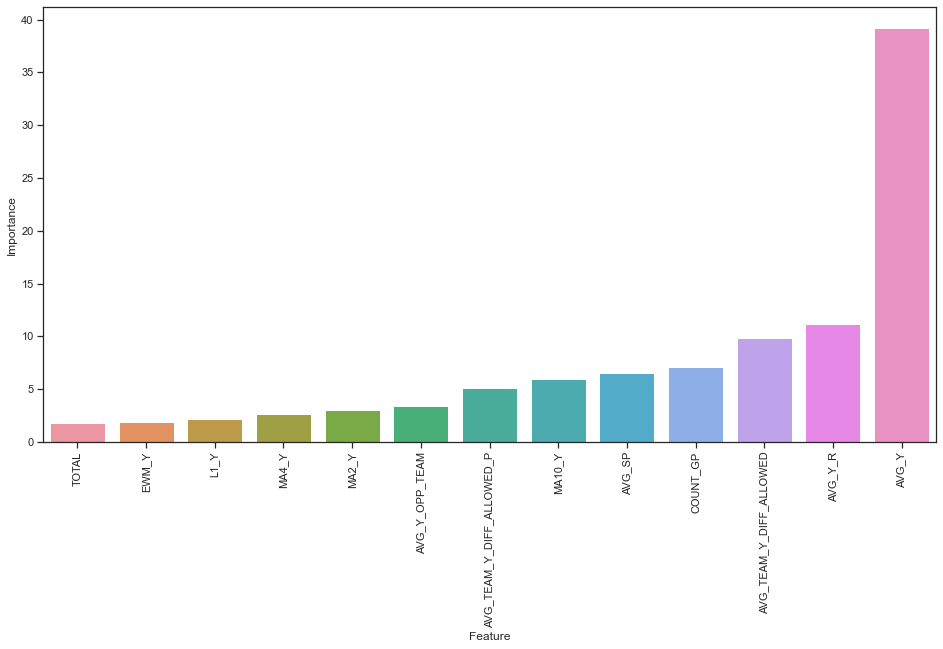

In [47]:
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Importance': feature_importances, 'Feature': selected_features})
feature_importance_df = feature_importance_df.sort_values(by='Importance')
ax = sns.barplot(x="Feature", y="Importance", data=feature_importance_df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

I will calculate a few metrics to evaluate the model's predictive power.

In [48]:
y_avg = feature_matrix.loc[X_test.index, 'AVG_Y']

# Kpi
print("R2 (explained variance):")
print("Model:", round(metrics.r2_score(y_test, y_hat, sample_weight=w_test), 3))
print("Baseline:", round(metrics.r2_score(y_test, y_avg, sample_weight=w_test), 3))

print("\nMean Absolute Error (Σ|y-pred|/n):")
print("Model:", round(metrics.mean_absolute_error(y_test, y_hat, sample_weight=w_test), 6))
print("Baseline:", round(metrics.mean_absolute_error(y_test, y_avg, sample_weight=w_test), 6))

print("\nRoot Mean Squared Error (sqrt(Σ(y-pred)^2/n)):")
print("Model:", round(np.sqrt(metrics.mean_squared_error(y_test, y_hat, sample_weight=w_test)), 6))
print("Baseline:", round(np.sqrt(metrics.mean_squared_error(y_test, y_avg, sample_weight=w_test)), 6))

R2 (explained variance):
Model: 0.05
Baseline: 0.01

Mean Absolute Error (Σ|y-pred|/n):
Model: 0.000487
Baseline: 0.000491

Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):
Model: 0.00062
Baseline: 0.000633


Residual analysis:

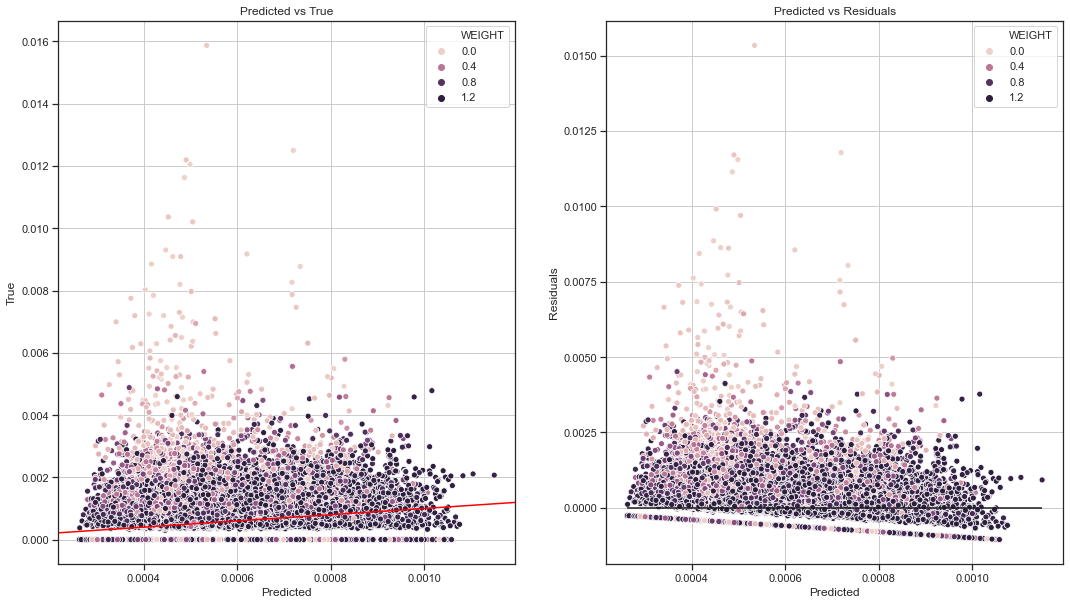

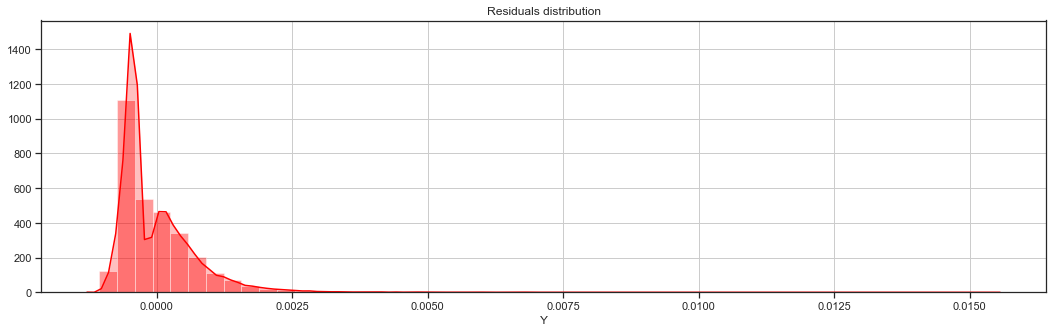

In [52]:
residuals = y_test - y_hat

# plot predicted vs true
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))
sns.scatterplot(y_hat, y_test, hue=w_test, ax=ax[0])
abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
ax[0].grid(True)
ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
ax[0].legend()
    
# plot predicted vs residuals
sns.scatterplot(y_hat, residuals, hue=w_test, ax=ax[1])
ax[1].grid(True)
ax[1].set(xlabel="Predicted", ylabel="Residuals", title="Predicted vs Residuals")
ax[1].hlines(y=0, xmin=np.min(y_hat), xmax=np.max(y_hat))
ax[1].legend()
plt.show()

fig, ax = plt.subplots(figsize=(18, 5))
sns.distplot(residuals, color="red", hist=True, kde=True, kde_kws={"shade":True}, ax=ax)
ax.grid(True)
ax.set(title="Residuals distribution")
plt.show()

In [50]:
stat, p = shapiro(residuals)
print(stat, p)

0.7731531858444214 0.0


Residuals are normally distributed and not heteroskedastic.